In [ ]:
import os
import itertools

# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os


import matplotlib.pyplot as plt
import seaborn as sns


from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import zipfile

# Create a .kaggle directory and move your API token there
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
os.rename('kaggle.json', os.path.expanduser('~/.kaggle/kaggle.json'))

# Set permissions (important on Linux/macOS)
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

In [ ]:
!pip install kaggle

# Download the dataset
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

# Unzip the dataset
with zipfile.ZipFile("brain-tumor-mri-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("Data/Brain Tumor")

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [ ]:
# Generate data paths with labels
train_data_dir = "Data/Brain Tumor/Training"
filepaths = []
labels = []

# Get folders names
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

In [ ]:

import os

def get_data_labels(directory):
    filepaths = []
    labels = []

    # Loop through each folder (each class)
    for label in os.listdir(directory):
        class_path = os.path.join(directory, label)
        if os.path.isdir(class_path):
            for fname in os.listdir(class_path):
                if fname.endswith(('.jpg', '.jpeg', '.png')):
                    fpath = os.path.join(class_path, fname)
                    filepaths.append(fpath)
                    labels.append(label)

    return filepaths, labels

In [ ]:
train_dir =  "Data/Brain Tumor/Training"
test_dir = "Data/Brain Tumor/Testing"

# Getting data using above function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


x reshaped: (1, 150, 150, 3)


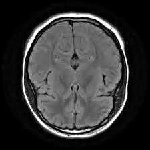

In [ ]:
# getting image to test output
im = load_img(train_paths[3], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

In [ ]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 40

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')



Image shape: (150, 150, 3)
Epochs: 40
Batch size: 32
Steps Per Epoch: 178
Validation steps: 40


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False, start_from_epoch=0)
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

In [ ]:
# Define the model architecture
model = models.Sequential([

    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(3, 3)),


    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),


    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.5, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])

model.summary()

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 46, 46, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])

Epoch 1/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 56s 263ms/step - accuracy: 0.4708 - loss: 1.0853 - val_accuracy: 0.7445 - val_loss: 0.6674 - learning_rate: 0.0010
Epoch 2/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7500 - loss: 0.4393 - val_accuracy: 0.7430 - val_loss: 0.6833 - learning_rate: 0.0010
Epoch 3/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 65s 236ms/step - accuracy: 0.7687 - loss: 0.5669 - val_accuracy: 0.7617 - val_loss: 0.5430 - learning_rate: 0.0010
Epoch 4/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8438 - loss: 0.3568 - val_accuracy: 0.7937 - val_loss: 0.4901 - learning_rate: 0.0010
Epoch 5/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 46s 259ms/step - accuracy: 0.8256 - loss: 0.4551 - val_accuracy: 0.8148 - val_loss: 0.4400 - learning_rate: 0.0010
Epoch 6/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9375 - loss: 0.2894 - val_accuracy: 0.8109 - val_loss: 0.4483 - learning_rate: 0.0010
Epoch 7/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 81s 457ms/step - accuracy: 0.8762 - 